↘︎ 下载: https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf
已保存: NotoSansCJKsc-Regular.otf  (16052 KB)
 已启用中文字体： Noto Sans CJK SC


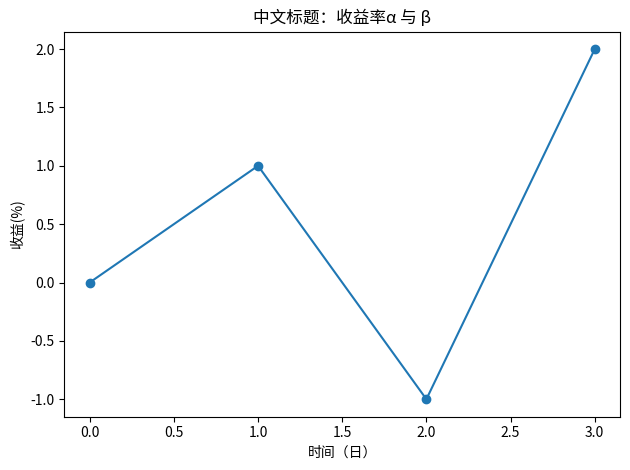

In [1]:
# === 一次性：下载中文字体 → 注册 → 配置 Matplotlib → 测试中文 ===
import os, sys, time, urllib.request
import matplotlib as mpl
from matplotlib import font_manager
import matplotlib.pyplot as plt

#  备选字体下载地址（按优先级尝试）
CANDIDATES = [
    # Noto Sans CJK SC
    ("NotoSansCJKsc-Regular.otf",
     "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf"),
    ("NotoSansCJKsc-Regular.otf",
     "https://raw.githubusercontent.com/googlefonts/noto-cjk/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf"),
    # Source Han Sans SC (思源黑体)
    ("SourceHanSansSC-Regular.otf",
     "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"),
]

def try_download(dest, url, timeout=25):
    try:
        print(f"↘︎ 下载: {url}")
        urllib.request.urlretrieve(url, dest)
        # 简单验收：大小>100KB
        if os.path.getsize(dest) < 100 * 1024:
            raise RuntimeError("下载文件异常（过小）")
        print(f"已保存: {dest}  ({os.path.getsize(dest)/1024:.0f} KB)")
        return True
    except Exception as e:
        print(f"下载失败: {e}")
        if os.path.exists(dest):
            try: os.remove(dest)
            except: pass
        return False

# 2) 若本地已存在可用字体，直接用；否则逐个下载尝试
font_path = None
for fname, url in CANDIDATES:
    if os.path.exists(fname):
        font_path = fname
        print(f"已有字体文件: {fname}")
        break
else:
    for fname, url in CANDIDATES:
        if try_download(fname, url):
            font_path = fname
            break

if not font_path:
    raise RuntimeError(" 无法下载中文字体。请检查网络/代理，或手动上传任一 OTF/TTF 后重试。")

# 3) 注册字体并设为默认 sans-serif
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()

mpl.rcParams["font.sans-serif"] = [font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42
mpl.rcParams["svg.fonttype"] = "none"

print(" 已启用中文字体：", font_name)

# 4) 画一张测试图
plt.figure()
plt.title("中文标题：收益率α 与 β")
plt.xlabel("时间（日）")
plt.ylabel("收益(%)")
plt.plot([0,1,2,3],[0,1,-1,2], marker="o")
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import pickle
import re
from typing import List, Union, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 添加中文字体支持
try:
    fm.fontManager.addfont('NotoSansSC-SemiBold.ttf')
    font_name = fm.FontProperties(fname='NotoSansSC-SemiBold.ttf').get_name()
    mpl.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])
except FileNotFoundError:
    print("中文字体文件 'NotoSansSC-SemiBold.ttf' 未找到，将使用默认字体。")

中文字体文件 'NotoSansSC-SemiBold.ttf' 未找到，将使用默认字体。


In [3]:
# 全局参数设置
# 数据日期范围参数
START_DATE = '2024-10-01'  # 数据开始日期
END_DATE = '2024-11-29'    # 数据结束日期

# 期货品种设置
SYMBOL_TYPES = ['寒武纪']  # 可以添加其他合约类型如 'IC', 'IH'

# --- 回归任务参数 ---
# 数据处理参数
LOOKBACK_WINDOW = 5        # 用于计算标准化参数的历史天数
TIMESTAMP_PER_SAMPLE = 8 # 每个样本的时间步长
K = 4                      # 用于计算未来价格走势的时间步长 (y[t] = (Bid1[t+k] - Ask1[t]) / Ask1[t])
RAW_N = 20                 # 前20列为原始、未标准化的订单簿特征 (5 levels * 2 sides * 2 (price+volume))

freq: str = "3000ms"   # 改这里即可：支持 "100ms" / "300ms" / "500ms" / "1s" 等
# 数据缓存路径
DATA_CACHE_DIR = "./data_cache"
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

In [ ]:
# --- 挂载 & 导入 ---
from google.colab import drive
drive.mount('/content/drive')

from typing import Union, Tuple, List
import pandas as pd
import numpy as np



def get_processed_data(
    start_date: Union[str, np.datetime64, pd.Timestamp],
    end_date:   Union[str, np.datetime64, pd.Timestamp] = None,
    symbol_types: List[str] = SYMBOL_TYPES,
    time_range: Tuple[str, str] = None,
    parquet_path: str = '/content/drive/MyDrive/2024_256.parquet',
) -> pd.DataFrame:
    """
    从本地 Parquet 读取 -> 按日期/标的/交易时段筛选
    -> 对每个交易日/交易时段按**全局 freq**强制对齐（重采样，backward 填充）。
    """
    # 1) 读文件
    try:
        print(f"正在从 '{parquet_path}' 加载数据...")
        df = pd.read_parquet(parquet_path)
        print(f"数据加载成功，共 {len(df)} 条记录。")
    except FileNotFoundError:
        print(f"错误：未找到文件 '{parquet_path}'。请确保文件路径正确。")
        return pd.DataFrame()

    # 2) 处理日期参数
    if end_date is None:
        end_date = start_date
    start_date_for_filter = pd.to_datetime(start_date).strftime('%Y%m%d')
    end_date_for_filter   = pd.to_datetime(end_date).strftime('%Y%m%d')
    print(f"将使用筛选日期范围: {start_date_for_filter} 到 {end_date_for_filter}")

    # 3) 基础字段规范和时间戳转换
    df['MDDate'] = df['MDDate'].astype(str)
    df['MDTime'] = (
        df['MDTime'].astype(str)
        .str.replace(r'\D', '', regex=True)
        .str.zfill(9)        # HHMMSSfff
        .str[:9]
    )
    df['Symbol'] = df['Symbol'].astype(str)

    print("正在高效转换时间戳...")
    df['Timestamp'] = pd.to_datetime(
        df['MDDate'] + ' ' + df['MDTime'],
        format='%Y%m%d %H%M%S%f',
        errors='coerce'
    )
    df.dropna(subset=['Timestamp'], inplace=True)
    df.sort_values('Timestamp', inplace=True)
    print("时间戳转换完成。")

    # 4) 日期与标的筛选
    date_mask   = df['MDDate'].between(start_date_for_filter, end_date_for_filter)
    symbol_mask = df['Symbol'].str.strip().str.startswith(tuple(symbol_types))
    result_df   = df[date_mask & symbol_mask].copy()
    if result_df.empty:
        print(f"在 {start_date_for_filter} 到 {end_date_for_filter} 范围内未找到合约类型为 {symbol_types} 的数据。")
        return pd.DataFrame()
    print(f"初步筛选后，找到 {len(result_df)} 条记录。")

    # 5) 交易时段（可被 time_range 覆盖）
    sessions = [
        (pd.to_datetime("09:30:00").time(), pd.to_datetime("11:30:00").time()),
        (pd.to_datetime("13:00:00").time(), pd.to_datetime("15:00:00").time()),
    ]
    if time_range is not None:
        sessions = [(pd.to_datetime(time_range[0]).time(),
                     pd.to_datetime(time_range[1]).time())]

    # 6) 必做重采样：按全局 freq 对齐 + backward 填充
    out_parts = []
    for day, df_day in result_df.groupby(result_df['Timestamp'].dt.date):
        for (t_start, t_end) in sessions:
            mask = ((df_day['Timestamp'].dt.time >= t_start) &
                    (df_day['Timestamp'].dt.time <= t_end))
            seg = (
                df_day.loc[mask]
                .drop_duplicates(subset=['Timestamp'], keep='last')
                .sort_values('Timestamp')
            )
            if seg.empty:
                continue

            g_start, g_end = seg['Timestamp'].iloc[0], seg['Timestamp'].iloc[-1]
            grid = pd.DataFrame({'Timestamp': pd.date_range(start=g_start, end=g_end, freq=freq)})

            aligned = pd.merge_asof(
                grid, seg, on='Timestamp',
                direction='backward', allow_exact_matches=True
            )
            out_parts.append(aligned)

    if not out_parts:
        print("所有所选时段内均无可对齐数据，返回空表。")
        return pd.DataFrame()

    result_df = (
        pd.concat(out_parts, ignore_index=True)
          .sort_values('Timestamp')
          .reset_index(drop=True)
    )
    print(f"[resample] 已按全局 freq='{freq}' 重采样完成，输出 {len(result_df)} 行。")

    # 7) 重命名与列选择
    result_df['Trade_Date'] = result_df['Timestamp'].dt.strftime('%Y-%m-%d')

    rename_map = {
        'Buy1Price': 'BidPrice1',     'Buy1OrderQty': 'BidVolume1',
        'Sell1Price': 'AskPrice1',    'Sell1OrderQty': 'AskVolume1',
        'Buy2Price': 'BidPrice2',     'Buy2OrderQty': 'BidVolume2',
        'Sell2Price': 'AskPrice2',    'Sell2OrderQty': 'AskVolume2',
        'Buy3Price': 'BidPrice3',     'Buy3OrderQty': 'BidVolume3',
        'Sell3Price': 'AskPrice3',    'Sell3OrderQty': 'AskVolume3',
        'Buy4Price': 'BidPrice4',     'Buy4OrderQty': 'BidVolume4',
        'Sell4Price': 'AskPrice4',    'Sell4OrderQty': 'AskVolume4',
        'Buy5Price': 'BidPrice5',     'Buy5OrderQty': 'BidVolume5',
        'Sell5Price': 'AskPrice5',    'Sell5OrderQty': 'AskVolume5',
        'LastPrice': 'LastPrice'
    }

    # # 若没有 LastPrice，则尝试用一档中价代替
    # if 'LastPrice' not in result_df.columns:
    #     if {'Buy1Price', 'Sell1Price'}.issubset(result_df.columns):
    #         result_df['LastPrice'] = (result_df['Buy1Price'] + result_df['Sell1Price']) / 2
    #     elif {'BidPrice1', 'AskPrice1'}.issubset(result_df.columns):
    #         result_df['LastPrice'] = (result_df['BidPrice1'] + result_df['AskPrice1']) / 2
    #     else:
    #         print("警告: 缺少一档买卖价，无法构造 LastPrice。")

    # 仅重命名存在的列
    rename_submap = {k: v for k, v in rename_map.items() if k in result_df.columns}
    result_df.rename(columns=rename_submap, inplace=True)

    required_columns = list(rename_map.values()) + ['Symbol', 'Timestamp', 'Trade_Date']
    final_cols = [col for col in required_columns if col in result_df.columns]

    return result_df[final_cols]


# --- 2. 标签生成 ---
def generate_multitask_labels(k: int, daily_data_dict: dict):
    """
    为多任务学习生成一组标签。
    【最终版】移除了不稳定的 y_lambda 任务，并全面提升了计算的稳健性。
    """
    assert k > 0, "k 必须为正整数"
    daily_y_dict = {}
    # 从标签名称列表中移除 y_lambda
    label_names = ['y_reg', 'y_rv', 'y_fillprob', 'y_roll', 'y_vpin', 'y_direction', 'y_upper_bound', 'y_lower_bound']

    for date, df in daily_data_dict.items():
        n = len(df)
        if n <= k:
            daily_y_dict[date] = pd.DataFrame(columns=label_names, dtype=np.float32)
            continue

        labels = pd.DataFrame(index=df.index, dtype=np.float32)

        mid_price = (df['AskPrice1'] + df['BidPrice1']) / 2
        log_mid_price_ret = np.log(mid_price).diff().fillna(0)

        entry_price = df['AskPrice1'].values
        exit_price = df['BidPrice1'].shift(-k).values
        y_reg = (exit_price - entry_price) / (entry_price + 1e-12)
        labels['y_reg'] = y_reg * 10000.0

        rv_raw = log_mid_price_ret.pow(2).rolling(window=k).sum().shift(-k)
        labels['y_rv'] = np.sqrt(np.maximum(rv_raw, 0)) * 10000.0

        future_min_ask = df['AskPrice1'].rolling(window=k).min().shift(-k)
        labels['y_fillprob'] = (future_min_ask <= df['BidPrice1']).astype(float)


        cov = log_mid_price_ret.rolling(window=k).cov(log_mid_price_ret.shift(1)).shift(-k)
        roll_spread_raw = 2 * np.sqrt(np.maximum(-cov, 0))
        labels['y_roll'] = roll_spread_raw * 10000.0

        buy_vol_diff = df['BidVolume1'].diff().fillna(0).clip(lower=0)
        sell_vol_diff = df['AskVolume1'].diff().fillna(0).clip(lower=0)
        total_volume = (buy_vol_diff + sell_vol_diff).sum()
        bucket_size = total_volume / 50 if total_volume > 0 else 1000

        vpin_values = []
        cum_vol = 0; buy_vol_bucket = 0; sell_vol_bucket = 0
        start_idx = 0
        for i in range(n):
            b_vol, s_vol = buy_vol_diff.iloc[i], sell_vol_diff.iloc[i]
            cum_vol += b_vol + s_vol
            buy_vol_bucket += b_vol
            sell_vol_bucket += s_vol
            if cum_vol >= bucket_size and cum_vol > 0:
                vpin = np.abs(buy_vol_bucket - sell_vol_bucket) / cum_vol
                vpin_values.extend([vpin] * (i - start_idx + 1))
                start_idx = i + 1
                cum_vol = 0; buy_vol_bucket = 0; sell_vol_bucket = 0

        if start_idx < n:
            last_vpin = vpin_values[-1] if vpin_values else 0
            vpin_values.extend([last_vpin] * (n - start_idx))

        labels['y_vpin'] = pd.Series(vpin_values, index=df.index, dtype=np.float32).shift(-k)

        # --- 计算新的辅助标签 ---
        # 1. y_direction (分类任务: 0=下跌, 1=不变, 2=上涨)
        future_mid_price = mid_price.shift(-k)
        price_change = future_mid_price - mid_price
        labels['y_direction'] = 1 # 默认为不变
        labels.loc[price_change > 1e-6, 'y_direction'] = 2 # 上涨
        labels.loc[price_change < -1e-6, 'y_direction'] = 0 # 下跌

        # 2. y_upper_bound 和 y_lower_bound (回归任务)
        future_max_mid = mid_price.rolling(window=k).max().shift(-k)
        future_min_mid = mid_price.rolling(window=k).min().shift(-k)

        # 将其表示为相对于当前价格的变化率 (BPS)
        labels['y_upper_bound'] = (future_max_mid - mid_price) / (mid_price + 1e-12) * 10000.0
        labels['y_lower_bound'] = (future_min_mid - mid_price) / (mid_price + 1e-12) * 10000.0

        labels.replace([np.inf, -np.inf], np.nan, inplace=True)
        labels.ffill(inplace=True)
        labels.bfill(inplace=True)
        labels.fillna(0, inplace=True)

        for col in labels.columns:
            if col == 'y_fillprob': continue
            mean, std = labels[col].mean(), labels[col].std()
            if std > 0:
                lower_bound, upper_bound = mean - 5 * std, mean + 5 * std
                labels[col] = labels[col].clip(lower_bound, upper_bound)

        daily_y_dict[date] = labels.values.astype(np.float32)

    return daily_y_dict, label_names


# --- 3. 特征生成  ---
def prepare_orderbook_data(data_df):
    """
    【增强版】在原有特征基础上，增加了高阶动态、多时间尺度、微观结构比率等高级特征。
    """
    features = []
    # --- 基础订单簿特征 (不变) ---
    for i in range(1, 6): features.append(data_df[f'AskPrice{i}'].values)
    for i in range(1, 6): features.append(data_df[f'AskVolume{i}'].values)
    for i in range(1, 6): features.append(data_df[f'BidPrice{i}'].values)
    for i in range(1, 6): features.append(data_df[f'BidVolume{i}'].values)

    # --- 基础衍生特征 (不变) ---
    for i in range(1, 5): features.append(data_df[f'AskPrice{i+1}'].values - data_df[f'AskPrice{i}'].values)
    for i in range(1, 5): features.append(data_df[f'BidPrice{i}'].values - data_df[f'BidPrice{i+1}'].values)
    for i in range(1, 6): features.append((data_df[f'AskPrice{i}'].values + data_df[f'BidPrice{i}'].values) / 2)
    for i in range(1, 6): features.append(data_df[f'AskPrice{i}'].values - data_df[f'BidPrice{i}'].values)
    ask_cum_vol = np.zeros(len(data_df)); bid_cum_vol = np.zeros(len(data_df))
    for i in range(1, 6):
        ask_cum_vol += data_df[f'AskVolume{i}'].values; bid_cum_vol += data_df[f'BidVolume{i}'].values
        features.append(ask_cum_vol.copy()); features.append(bid_cum_vol.copy())
    features.append(bid_cum_vol / (ask_cum_vol + bid_cum_vol + 1e-12))

    mid_price_l1 = (data_df['BidPrice1'] + data_df['AskPrice1']) / 2
    returns = mid_price_l1.pct_change().fillna(0)
    price_change = mid_price_l1.diff().fillna(0)
    for window in [5, 10, 20]:
        features.append(price_change.rolling(window=window, min_periods=1).sum().fillna(0).values)
    for window in [10, 30, 60]:
        features.append(returns.rolling(window=window, min_periods=1).std().fillna(0).values)

    prev_bid_price = data_df['BidPrice1'].shift(1).bfill()
    prev_ask_price = data_df['AskPrice1'].shift(1).bfill()
    delta_bid_vol = data_df['BidVolume1'].diff().fillna(0)
    delta_ask_vol = data_df['AskVolume1'].diff().fillna(0)
    ofi_raw = np.zeros_like(mid_price_l1.values, dtype=float)
    ofi_raw[data_df['BidPrice1'] > prev_bid_price] = data_df.loc[data_df['BidPrice1'] > prev_bid_price, 'BidVolume1']
    ofi_raw[data_df['AskPrice1'] < prev_ask_price] = -data_df.loc[data_df['AskPrice1'] < prev_ask_price, 'AskVolume1']
    is_price_stable = (data_df['BidPrice1'] == prev_bid_price) & (data_df['AskPrice1'] == prev_ask_price)
    ofi_raw[is_price_stable] = (delta_bid_vol - delta_ask_vol)[is_price_stable]
    features.append(ofi_raw)
    for window in [10, 30, 60]:
        features.append(pd.Series(ofi_raw).rolling(window=window, min_periods=1).sum().fillna(0).values)

    seconds_in_day = (data_df['Timestamp'] - data_df['Timestamp'].dt.normalize()).dt.total_seconds()
    trading_day_seconds = 14400
    features.append(np.sin(2 * np.pi * seconds_in_day / trading_day_seconds))
    features.append(np.cos(2 * np.pi * seconds_in_day / trading_day_seconds))
    features.append((data_df['Timestamp'].dt.hour < 12).astype(int).values)
    features.append((data_df['Timestamp'].dt.hour >= 13).astype(int).values)

    for i in range(1, 6): features.append(data_df[f'BidPrice{i}'].diff().fillna(0).values)
    for i in range(1, 6): features.append(data_df[f'AskPrice{i}'].diff().fillna(0).values)
    for i in range(1, 6): features.append(data_df[f'BidVolume{i}'].diff().fillna(0).values)
    for i in range(1, 6): features.append(data_df[f'AskVolume{i}'].diff().fillna(0).values)

    spread1 = data_df['AskPrice1'] - data_df['BidPrice1']
    spread_change_pct = spread1.pct_change().fillna(0).replace([np.inf, -np.inf], 0)
    features.append(spread_change_pct.values)

    v_ask_price = (data_df['AskPrice1'] * data_df['AskVolume1'] + data_df['AskPrice2'] * data_df['AskVolume2']) / (data_df['AskVolume1'] + data_df['AskVolume2'] + 1e-12)
    v_bid_price = (data_df['BidPrice1'] * data_df['BidVolume1'] + data_df['BidPrice2'] * data_df['BidVolume2']) / (data_df['BidVolume1'] + data_df['BidVolume2'] + 1e-12)
    vwap = ((v_ask_price + v_bid_price) / 2).ffill().bfill()
    vwap_change_pct = vwap.pct_change().fillna(0).replace([np.inf, -np.inf], 0)
    features.append(vwap_change_pct.values)

    total_bid_volume = data_df[[f'BidVolume{i}' for i in range(1, 6)]].sum(axis=1)
    total_ask_volume = data_df[[f'AskVolume{i}' for i in range(1, 6)]].sum(axis=1)
    obi = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume + 1e-12)
    features.append(obi.values)
    weighted_bid_price = np.sum([data_df[f'BidPrice{i}'] * data_df[f'BidVolume{i}'] for i in range(1, 6)], axis=0) / (total_bid_volume + 1e-12)
    weighted_ask_price = np.sum([data_df[f'AskPrice{i}'] * data_df[f'AskVolume{i}'] for i in range(1, 6)], axis=0) / (total_ask_volume + 1e-12)
    features.append(weighted_bid_price.values)
    features.append(weighted_ask_price.values)

    # --------------------------------------------------------------------------------------
    # --- 【新增特征类别1: 高阶动态特征】 ---
    # 价格加速度: 趋势是在加速还是减速？
    price_acceleration = price_change.diff().fillna(0)
    features.append(price_acceleration.values)
    for window in [10, 30, 60]:
        features.append(price_acceleration.rolling(window=window, min_periods=1).sum().fillna(0).values)

    # 不平衡度的波动性: 市场情绪是稳定还是在剧烈摆动？
    obi_volatility = obi.rolling(window=20, min_periods=1).std().fillna(0)
    features.append(obi_volatility.values)
    ofi_volatility = pd.Series(ofi_raw).rolling(window=20, min_periods=1).std().fillna(0)
    features.append(ofi_volatility.values)

    # --- 【新增特征类别2: 多时间尺度特征 (EMA)】 ---
    # 使用EMA（指数移动平均）捕捉不同时间尺度下的趋势
    # 短期 vs 中期
    ema_mid_price_fast = mid_price_l1.ewm(span=10, adjust=False).mean()
    ema_mid_price_slow = mid_price_l1.ewm(span=40, adjust=False).mean()
    features.append((ema_mid_price_fast - ema_mid_price_slow).values) # MACD on mid-price

    # 中期 vs 长期
    ema_mid_price_very_slow = mid_price_l1.ewm(span=120, adjust=False).mean()
    features.append((ema_mid_price_slow - ema_mid_price_very_slow).values)

    # OFI 和 OBI 的多尺度信息
    ema_obi_fast = obi.ewm(span=20, adjust=False).mean()
    ema_obi_slow = obi.ewm(span=60, adjust=False).mean()
    features.append((ema_obi_fast - ema_obi_slow).values) # MACD on OBI

    ema_ofi_fast = pd.Series(ofi_raw).ewm(span=20, adjust=False).mean()
    ema_ofi_slow = pd.Series(ofi_raw).ewm(span=60, adjust=False).mean()
    features.append((ema_ofi_fast - ema_ofi_slow).values) # MACD on OFI

    # --- 【新增特征类别3: 微观结构比率】 ---
    # 描述订单簿“形状”的无量纲特征
    # 挂单量比率: 盘口第一档的深度占前五档总深度的比例
    features.append((data_df['BidVolume1'] / (total_bid_volume + 1e-12)).values)
    features.append((data_df['AskVolume1'] / (total_ask_volume + 1e-12)).values)

    # 盘口第一档和第二档的量价比
    features.append((data_df['BidVolume1'] / (data_df['BidVolume2'] + 1e-12)).values)
    features.append((data_df['AskVolume1'] / (data_df['AskVolume2'] + 1e-12)).values)

    # 价差比率: 第二档价差相对于第一档价差的倍数
    spread2 = data_df['AskPrice2'] - data_df['BidPrice2']
    features.append((spread2 / (spread1 + 1e-12)).values)

    # --- 【新增特征类别4: 流动性成本代理】 ---
    # 市场冲击成本代理: 移动一个tick的成本有多高？
    # 该值越小，说明流动性越好，冲击成本越低。
    market_impact_cost = spread1 / (data_df['BidVolume1'] + data_df['AskVolume1'] + 1e-12)
    features.append(market_impact_cost.values)

    # 订单簿斜率代理: 每单位价格变动能吸收多少订单量？
    price_diff_bid_1_2 = data_df['BidPrice1'] - data_df['BidPrice2']
    price_diff_ask_1_2 = data_df['AskPrice2'] - data_df['AskPrice1']
    # 避免除以0
    slope_bid = data_df['BidVolume1'] / (price_diff_bid_1_2.where(price_diff_bid_1_2 > 0, 0.001))
    slope_ask = data_df['AskVolume1'] / (price_diff_ask_1_2.where(price_diff_ask_1_2 > 0, 0.001))
    features.append(slope_bid.values)
    features.append(slope_ask.values)
    # --------------------------------------------------------------------------------------

    final_features = np.array(features, dtype=np.float32).T
    if np.any(np.isnan(final_features)) or np.any(np.isinf(final_features)):
        print("警告: 特征矩阵中检测到 NaN 或 Inf 值，将用0填充。")
        final_features = np.nan_to_num(final_features, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"【增强版】总特征数量: {final_features.shape[1]}")
    return final_features

# --- 4. 多日数据处理 ---
def process_multi_day_data(start_date, end_date=None, symbol_types=SYMBOL_TYPES):
    if end_date is None:
        end_date = (pd.to_datetime(start_date) + pd.Timedelta(days=LOOKBACK_WINDOW + 7)).strftime("%Y-%m-%d")

    result_by_symbol = {}
    for symbol_type in symbol_types:
        print(f"\n===== 处理品种: {symbol_type} =====")
        raw_data = get_processed_data(start_date, end_date, symbol_types=[symbol_type])
        if raw_data.empty: continue

        daily_raw_dict = {
            pd.to_datetime(date).strftime("%Y-%m-%d"): g.reset_index(drop=True)
            for date, g in raw_data.groupby("Trade_Date")
        }
        daily_orderbook_dict = {d: prepare_orderbook_data(df) for d, df in daily_raw_dict.items()}

        normalization_mean_dict, normalization_stddev_dict, clipping_bounds_dict = {}, {}, {}
        dates_list = sorted(list(daily_orderbook_dict.keys()))
        if len(dates_list) <= LOOKBACK_WINDOW:
            print(f"警告: 可用交易日 {len(dates_list)} <= LOOKBACK_WINDOW {LOOKBACK_WINDOW}，将用所有历史估计标准化参数。")

        # --- START: 核心修改 - 只对衍生特征计算标准化参数 ---
        for i in range(LOOKBACK_WINDOW, len(dates_list)):
            date = dates_list[i]
            look_back_days = dates_list[i-LOOKBACK_WINDOW:i]
            stack_all_features = np.vstack([daily_orderbook_dict[dd] for dd in look_back_days])

            # #注释更改2: 这里我们选特征只用20列以后，所以标准化参数也只针对这部分计算
            stack_derived_features = stack_all_features[:, RAW_N:]

            # 截断边界仍然在所有特征上计算，这有助于了解原始值的范围
            lower_bounds_all = np.percentile(stack_all_features, 1, axis=0)
            upper_bounds_all = np.percentile(stack_all_features, 99, axis=0)
            clipping_bounds_dict[date] = (lower_bounds_all, upper_bounds_all)

            # 仅截断衍生特征部分，用于计算均值和标准差
            clipped_stack_derived = np.clip(stack_derived_features,
                                            lower_bounds_all[RAW_N:],
                                            upper_bounds_all[RAW_N:])

            # 仅计算衍生特征的均值和标准差
            means_derived = np.mean(clipped_stack_derived, axis=0)
            stds_derived = np.std(clipped_stack_derived, axis=0)
            stds_derived[stds_derived < 1e-8] = 1.0

            # 为了方便后续使用，创建一个完整的参数数组
            # 前20列的均值为0，标准差为1，这样即使误操作(x-0)/1也不会改变原始值
            full_means = np.zeros(stack_all_features.shape[1], dtype=np.float32)
            full_stds = np.ones(stack_all_features.shape[1], dtype=np.float32)

            # 将计算好的衍生特征参数填入
            full_means[RAW_N:] = means_derived.astype(np.float32)
            full_stds[RAW_N:] = stds_derived.astype(np.float32)

            normalization_mean_dict[date] = full_means
            normalization_stddev_dict[date] = stds_derived.astype(np.float32) # 这里存stddev_dict只存衍生部分的即可，因为下面只用衍生的std
            normalization_stddev_dict[date] = stds_derived # Re-assign for clarity, mean is full, std is partial. Let's fix this for consistency.

            # Let's be consistent and store full arrays for both.
            normalization_mean_dict[date] = full_means
            normalization_stddev_dict[date] = full_stds
        # --- END: 核心修改 ---

        daily_norm_data_dict = {}
        for i in range(LOOKBACK_WINDOW, len(dates_list)):
            date = dates_list[i]

            # --- START: 核心修改 - 构建混合矩阵 ---
            # 1. 分离当天的原始特征和衍生特征
            features_all = daily_orderbook_dict[date].copy()
            features_base = features_all[:, :RAW_N]      # 前20列原始特征
            features_derived = features_all[:, RAW_N:] # 20列之后的衍生特征

            # 2. 获取用于标准化的参数
            lower_bounds_all, upper_bounds_all = clipping_bounds_dict[date]
            means_full, stds_full = normalization_mean_dict[date], normalization_stddev_dict[date]

            # 提取衍生特征对应的参数
            lower_bounds_derived = lower_bounds_all[RAW_N:]
            upper_bounds_derived = upper_bounds_all[RAW_N:]
            means_derived = means_full[RAW_N:]
            stds_derived = stds_full[RAW_N:]

            # 3. 只对衍生特征进行截断和标准化
            clipped_features_derived = np.clip(features_derived, lower_bounds_derived, upper_bounds_derived)
            norm_features_derived = (clipped_features_derived - means_derived) / stds_derived

            # 4. #注释更改1: 将原始的前20列和标准化后的衍生特征拼接成最终的混合矩阵
            final_features = np.hstack([features_base, norm_features_derived])

            daily_norm_data_dict[date] = final_features

            # 5. #注释更改3: 验证混合矩阵结构，方便检查
            if i == LOOKBACK_WINDOW: # 只在处理第一天时打印一次
                print("\n--- 验证混合矩阵结构 ---")
                print(f"前20列 (原始值) 的均值示例: {np.mean(final_features[:, :RAW_N], axis=0)[:5]}")
                print(f"后半部分 (标准化衍生特征) 的均值示例: {np.mean(final_features[:, RAW_N:], axis=0)[:5]}")
                print(f"后半部分 (标准化衍生特征) 的标准差示例: {np.std(final_features[:, RAW_N:], axis=0)[:5]}")
                print("\n>>> 检查点: 前20列均值应为较大的原始价格/量级，后半部分均值接近0，标准差接近1。")
                print("--- 验证完毕 ---\n")
            # --- END: 核心修改 ---

        daily_label_dict, label_names = generate_multitask_labels(K, daily_raw_dict)
        # --- 在这里内联删除脏样本（保持 X/Y 对齐） ---
        PRUNE_CAP_BPS   = 10000    # 5秒持仓建议 10000 bps
        DROP_TAIL_K     = True   # 每天最后 K 行由于 shift(-K) 无未来值，直接删
        DROP_BAD_PRICE  = True   # Ask/Bid <= 0 或 非数 删
        y_idx = label_names.index('y_reg')

        kept_total, drop_total = 0, 0
        for d in sorted(set(daily_label_dict) & set(daily_norm_data_dict)):
            # 取并对齐长度
            y = daily_label_dict[d]
            if isinstance(y, pd.DataFrame):
                y = y.to_numpy()
            else:
                y = np.asarray(y)
            x = np.asarray(daily_norm_data_dict[d])
            n = min(len(y), len(x))
            if n == 0:
                continue
            y = y[:n]; x = x[:n]

            # 初始保留
            keep = np.ones(n, dtype=bool)

            # 1) 丢最后 K 行（避免 bid_future(+K)=NaN）
            tail_mask = np.zeros(n, dtype=bool)
            if DROP_TAIL_K and n > K:
                tail_mask[-K:] = True
                keep &= ~tail_mask

            # 2) y_reg 非数 或 绝对值超阈
            yreg = y[:, y_idx]
            nonfinite_mask = ~np.isfinite(yreg)
            cap_mask = np.abs(yreg) > PRUNE_CAP_BPS
            keep &= np.isfinite(yreg) & (np.abs(yreg) <= PRUNE_CAP_BPS)

            # 3) 价格为 0/负/非数（用原始数据更可靠）
            price_mask = np.zeros(n, dtype=bool)
            if DROP_BAD_PRICE and d in daily_raw_dict:
                ask = pd.to_numeric(daily_raw_dict[d]['AskPrice1'], errors='coerce').to_numpy()[:n]
                bid = pd.to_numeric(daily_raw_dict[d]['BidPrice1'], errors='coerce').to_numpy()[:n]
                bad_price = ~(np.isfinite(ask) & np.isfinite(bid) & (ask > 0) & (bid > 0))
                price_mask = bad_price
                keep &= ~bad_price

            dropped = int((~keep).sum())
            kept    = int(keep.sum())
            if dropped:
                # 说明：各原因计数可能重叠（总数按并集计算）
                c_tail = int(tail_mask.sum())
                c_nonf = int(nonfinite_mask.sum())
                c_cap  = int(cap_mask.sum())
                c_price= int(price_mask.sum())
                print(f"[prune] {d}: drop {dropped}/{n} rows "
                      f"(tailK={c_tail}, |y_reg|>{PRUNE_CAP_BPS}bps={c_cap}, "
                      f"nonfinite={c_nonf}, bad_price={c_price})")
                bad_idx = np.where(~keep)[0][:5]
                for j in bad_idx:
                    ts = daily_raw_dict[d]['Timestamp'].iloc[j] if 'Timestamp' in daily_raw_dict[d].columns else None
                    yv = y[j, y_idx] if j < len(y) else None
                    aj = ask[j] if 'ask' in locals() and j < len(ask) else None
                    bj = bid[j] if 'bid' in locals() and j < len(bid) else None
                    print(f"    idx={j} y_reg={yv} ask={aj} bid={bj} ts={ts}")

            # 回写（保持 X/Y 对齐）
            daily_label_dict[d]      = y[keep]
            daily_norm_data_dict[d]  = x[keep]
            kept_total += kept; drop_total += dropped

        print(f"[prune] total dropped: {drop_total}, kept: {kept_total}")


        result_by_symbol[symbol_type] = {
            "daily_norm_data_dict": daily_norm_data_dict,
            "daily_label_dict": daily_label_dict, "label_names": label_names,
            "norm_mean_dict": normalization_mean_dict, "norm_stddev_dict": normalization_stddev_dict,
            "clipping_bounds_dict": clipping_bounds_dict, "daily_orderbook_dict": daily_orderbook_dict,
            "daily_raw_dict": daily_raw_dict,
        }
        print(f"{symbol_type} 数据处理完成，可用日期: {sorted(list(daily_norm_data_dict.keys()))}")

    return result_by_symbol

# --- 5. 生成训练/测试样本 ---
def generate_X_y(daily_norm_data_dict, daily_label_dict):
    all_x, all_y = [], []
    valid_dates = sorted(list(set(daily_norm_data_dict.keys()) & set(daily_label_dict.keys())))

    for date in valid_dates:
        features, labels = daily_norm_data_dict[date], daily_label_dict[date]
        num_labels = len(labels)
        if num_labels > 0:
            all_x.append(features[:num_labels, :]); all_y.append(labels)

    if not all_x: return None, None
    data_x, data_y_multi = np.vstack(all_x), np.vstack(all_y)

    N, P_x = data_x.shape
    if N < TIMESTAMP_PER_SAMPLE: return None, None

    x = np.zeros([(N - TIMESTAMP_PER_SAMPLE + 1), TIMESTAMP_PER_SAMPLE, P_x])
    for i in range(N - TIMESTAMP_PER_SAMPLE + 1):
        x[i] = data_x[i:(i + TIMESTAMP_PER_SAMPLE), :]

    x = x.reshape(x.shape + (1,))
    y_multi = data_y_multi[(TIMESTAMP_PER_SAMPLE - 1):, :]
    return x, y_multi


# --- 6. 辅助及可视化函数 ---
def save_processed_data(data, filename):
    with open(os.path.join(DATA_CACHE_DIR, filename), 'wb') as f:
        pickle.dump(data, f)
    print(f"数据已保存到 {os.path.join(DATA_CACHE_DIR, filename)}")

def load_processed_data(filename):
    file_path = os.path.join(DATA_CACHE_DIR, filename)
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    return None

def visualize_regression_data(y_true, y_pred, symbol_type):
    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.3, label='预测 vs. 真实 (BPS)')
    lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='y=x (完美预测)')
    plt.xlabel("真实收益率 (True Values, BPS)", fontsize=12)
    plt.ylabel("预测收益率 (Predictions, BPS)", fontsize=12)
    plt.title(f"{symbol_type} - 主任务回归预测结果", fontsize=14)
    plt.legend(); plt.grid(True); plt.axis('equal'); plt.tight_layout()
    save_path = os.path.join(vis_output_dir, f'{symbol_type}_regression_scatter.png')
    plt.savefig(save_path)
    print(f"回归散点图已保存至: {save_path}")
    plt.show()

def plot_training_history(history, symbol_type):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='训练损失 (Train Loss)')
    plt.plot(history['val_loss'], label='验证损失 (Validation Loss)')
    plt.title(f'{symbol_type} 模型总损失历史', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Combined Loss', fontsize=12)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)
    save_path = os.path.join(vis_output_dir, f'{symbol_type}_loss_history.png')
    plt.savefig(save_path)
    print(f"训练历史图已保存至: {save_path}")
    plt.show()

In [ ]:
# ==== 保留原有功能 + 新增 y_reg>0 机会数统计 ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 机会口径可调
THRESHOLD_BPS = 0.0   # 判定阈值：y_reg > THRESHOLD_BPS
USE_GE        = False # 改成 True 则用 ≥ 阈值

def _extract_ycol(v, label_names, col='y_reg'):
    """从 DataFrame/ndarray 中抽取指定列，返回一维 ndarray。"""
    idx = label_names.index(col)
    if isinstance(v, pd.DataFrame):
        if col in v.columns:
            return v[col].to_numpy()
        arr = v.to_numpy()
        return arr if arr.ndim == 1 else arr[:, idx]
    arr = np.asarray(v)
    return arr if arr.ndim == 1 else arr[:, idx]

def count_yreg_by_day(daily_label_dict, label_names, thr=0.0, col='y_reg', ge=False):
    """兼容 DataFrame 或 ndarray 的按日机会数统计，返回 DataFrame 和合计。"""
    rows, all_pos, all_total = [], 0, 0
    cmp = (lambda a: a >= thr) if ge else (lambda a: a > thr)
    for d in sorted(daily_label_dict):
        v = daily_label_dict[d]
        if v is None:
            continue
        arr = _extract_ycol(v, label_names, col)
        arr = arr[np.isfinite(arr)]
        n = int(arr.size)
        k = int(np.sum(cmp(arr)))
        rows.append([str(d), k, n, (k/n if n else np.nan)])
        all_pos += k; all_total += n
    return pd.DataFrame(rows, columns=['date','count_pos','total','share']), all_pos, all_total

# --- 执行多日数据处理（原样保留） ---
result_by_symbol = process_multi_day_data(START_DATE, END_DATE, symbol_types=SYMBOL_TYPES)

if result_by_symbol:
    print("\n===== 数据处理完成，开始可视化标签分布（保留） + 统计 y_reg 机会数（新增） =====")
    for symbol_type, data_dict in result_by_symbol.items():
        print(f"\n品种: {symbol_type}")

        if not data_dict.get('daily_norm_data_dict'):
            print(f"品种 {symbol_type} 没有足够的数据。")
            continue

        # 生成并显示多任务训练数据形状（原样保留）
        X, y_multi = generate_X_y(data_dict['daily_norm_data_dict'], data_dict['daily_label_dict'])
        label_names = data_dict.get('label_names', [])

        if X is not None and y_multi is not None and label_names:
            print(f"生成的训练数据形状: X: {X.shape}, y_multi: {y_multi.shape}")
            print(f"标签名称: {label_names}")
            print(f"y_multi 示例 (前5行):\n{y_multi[:5, :]}")

            # --- 原功能：为每个任务单独绘制标签分布直方图 ---
            num_tasks = y_multi.shape[1]
            ncols = 3
            nrows = (num_tasks + ncols - 1) // ncols

            fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
            axes = np.array(axes).reshape(-1)  # 展平更稳健

            for i in range(num_tasks):
                task_name = label_names[i]
                task_data = y_multi[:, i]

                ax = axes[i]
                ax.hist(task_data, bins=100, alpha=0.75,
                        label=f'均值: {np.nanmean(task_data):.2f}\n标准差: {np.nanstd(task_data):.2f}')
                ax.set_title(f'{symbol_type} - 标签分布: {task_name}')
                ax.set_xlabel('值 (BPS 或其他单位)')
                ax.set_ylabel('频数')
                ax.grid(True, alpha=0.3)
                ax.legend()

            # 隐藏多余的子图
            for j in range(num_tasks, len(axes)):
                fig.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

            # --- 新增：统计 y_reg 机会数（总体 + 按日 Top5），不影响以上绘图 ---
            if 'y_reg' in label_names:
                y_idx = label_names.index('y_reg')
                y = np.asarray(y_multi[:, y_idx])
                y = y[np.isfinite(y)]  # 过滤 NaN/inf

                total = int(y.size)
                pos   = int(np.sum(y >= THRESHOLD_BPS)) if USE_GE else int(np.sum(y > THRESHOLD_BPS))
                if THRESHOLD_BPS == 0.0:
                    eq0 = int(np.sum(y == 0.0))
                    neg = total - pos - eq0
                    print(f"[总体] y_reg>{THRESHOLD_BPS}: {pos} / {total} = {pos/total:.2%} | =0: {eq0} ({eq0/total:.2%}) | <0: {neg} ({neg/total:.2%})")
                else:
                    print(f"[总体] y_reg>{THRESHOLD_BPS}: {pos} / {total} = {pos/total:.2%}")

                # 按日
                if data_dict.get('daily_label_dict'):
                    day_df, all_pos, all_total = count_yreg_by_day(
                        data_dict['daily_label_dict'], label_names,
                        thr=THRESHOLD_BPS, col='y_reg', ge=USE_GE
                    )
                    if not day_df.empty:
                        print("\n按日 Top5（share 最大）:")
                        print(day_df.sort_values('share', ascending=False).head(5)
                              .to_string(index=False, formatters={'share': lambda x: f'{x:.2%}' if pd.notna(x) else 'NA'}))
                        print("\n按日 Top5（count_pos 最大）:")
                        print(day_df.sort_values('count_pos', ascending=False).head(5)
                              .to_string(index=False, formatters={'share': lambda x: f'{x:.2%}' if pd.notna(x) else 'NA'}))
                        print(f"\n[按日合计] y_reg>{THRESHOLD_BPS}: {all_pos} / {all_total} = {all_pos/all_total:.2%}")
            else:
                print("未找到 y_reg 标签，跳过机会数统计。")

        # 原功能：保存处理后的数据
        save_processed_data(data_dict, f'{symbol_type}_processed_data_regression.pkl')
else:
    print("数据处理失败，请检查日期范围或本地Parquet文件 'IM00_subset.parquet'。")


In [ ]:
# ==== Feature Selection using ONLY the earliest 50% of days (no-leak) ====
import os, math
import numpy as np
import pandas as pd
import lightgbm as lgb

# 从衍生特征中选出前 N 个最重要的；最终特征 = 前 RAW_N + TopK(衍生)
NUM_TOP_DERIVED_FEATURES = 86
RANDOM_STATE = 42

for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*25} 为品种 {symbol_type} 进行特征选择（仅用最早 50% 交易日） {'='*25}")

    processed_data_path = os.path.join(DATA_CACHE_DIR, f'{symbol_type}_processed_data_regression.pkl')
    data_dict = load_processed_data(f'{symbol_type}_processed_data_regression.pkl')
    if data_dict is None:
        print(f"未找到 {symbol_type} 的缓存数据，跳过特征选择。")
        continue

    if 'daily_norm_data_dict' not in data_dict or 'daily_label_dict' not in data_dict:
        print("数据字典缺少 'daily_norm_data_dict' 或 'daily_label_dict'。跳过。")
        continue

    daily_norm_data = data_dict['daily_norm_data_dict']
    daily_label     = data_dict['daily_label_dict']

    # 1) 以“交易日”为单位对齐，并按日期排序
    valid_dates = sorted(set(daily_norm_data.keys()) & set(daily_label.keys()))
    num_days = len(valid_dates)
    if num_days < 2:
        print(f"{symbol_type}: 可用交易日过少（{num_days}），跳过。")
        continue

    # 2) 只使用最早 50% 的交易日作为「特征选择全集」
    half_idx = max(1, math.floor(num_days * 0.5))
    fs_dates = valid_dates[:half_idx]  # Feature Selection dates (earliest half)
    print(f"{symbol_type}: 总交易日={num_days} | 用于特征选择的最早 50% 交易日数={len(fs_dates)}")
    if len(fs_dates) == 0:
        print(f"{symbol_type}: 50% 子集为空，跳过。")
        continue

    # 3) 在这 50% 内扁平化样本（逐日拼接；不跨日滑窗）
    X_list, y_list = [], []
    for d in fs_dates:
        F = daily_norm_data[d]
        L = daily_label[d]
        n = min(len(F), len(L))
        if n <= 0:
            continue
        # 允许 F/L 为 DataFrame 或 ndarray，统一扁平化为 ndarray
        X_list.append(np.asarray(F[:n, :]))
        y_list.append(np.asarray(L[:n, :]))

    if not X_list:
        print(f"{symbol_type}: 50% 子集中无样本，跳过。")
        continue

    X_flat = np.vstack(X_list)               # [N, F]
    y_multi_flat = np.vstack(y_list)         # [N, L]
    y_reg_flat = y_multi_flat[:, 0].ravel()  # 仅用主任务 y_reg 做重要度

    # 4) 仅以“衍生特征”作为 LGBM 的输入
    if X_flat.shape[1] <= RAW_N:
        print(f"{symbol_type}: 没有衍生特征（F={X_flat.shape[1]} <= RAW_N={RAW_N}），跳过。")
        continue

    X_derived = X_flat[:, RAW_N:]
    num_derived = X_derived.shape[1]
    print(f"{symbol_type}: 用于 LGBM 的衍生特征形状: {X_derived.shape}；目标 y 形状: {y_reg_flat.shape}")

    # 5) 在「最早 50%」内部做顺序切分：前 90% 训练、后 10% 验证（不打乱、不使用后半段的任何数据）
    split_idx = int(len(X_derived) * 0.9)
    split_idx = min(max(split_idx, 1), len(X_derived) - 1)  # 保证两端均非空

    X_tr, y_tr = X_derived[:split_idx], y_reg_flat[:split_idx]
    X_va, y_va = X_derived[split_idx:], y_reg_flat[split_idx:]
    print(f"{symbol_type}: 50% 子集内切分 -> 训练样本={len(X_tr)}，验证样本={len(X_va)}")

    # 6) 训练 LGBM 拿重要度（仅在 50% 子集上）
    lgbm = lgb.LGBMRegressor(
        objective='regression_l1',
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        n_jobs=-1,
        seed=RANDOM_STATE
    )
    if len(X_va) >= 32:
        lgbm.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='mae',
            callbacks=[lgb.early_stopping(stopping_rounds=10, first_metric_only=True, verbose=False)]
        )
    else:
        # 验证样本太少则不做早停
        lgbm.fit(X_tr, y_tr)

    # 7) 重要度统计 & 选 TopK（TopK 也只来自这 50% 子集训练得到的模型）
    importances = lgbm.feature_importances_
    if importances is None or len(importances) != num_derived:
        importances = np.zeros(num_derived, dtype=np.float32)

    feature_importance_df = (
        pd.DataFrame({"derived_feature_index": np.arange(num_derived), "importance": importances})
          .sort_values("importance", ascending=False, kind="mergesort")
    )
    print("\n衍生特征重要性排名前10位（基于最早 50% 训练得到）:")
    print(feature_importance_df.head(10))

    top_k = int(min(NUM_TOP_DERIVED_FEATURES, num_derived))
    top_derived_indices_local = feature_importance_df['derived_feature_index'].head(top_k).to_numpy()
    top_absolute_indices = (top_derived_indices_local + RAW_N).tolist()  # 映射回全量特征的绝对索引

    # 8) 合并“前 RAW_N（标准化的原始量价副本）+ 衍生 TopK”
    base_raw_indices = list(range(RAW_N))
    final_selected_indices = sorted(set(base_raw_indices + top_absolute_indices))

    print(f"\n最终特征数: {len(final_selected_indices)} "
          f"(含 {len(base_raw_indices)} 个原始副本 + {len(top_absolute_indices)} 个衍生TopK；"
          f"衍生总数={num_derived}; 仅用最早 50% 的日子训练 LGBM)")

    # 9) 保存
    data_dict['selected_feature_indices'] = final_selected_indices
    save_processed_data(data_dict, f'{symbol_type}_processed_data_regression.pkl')
    print(f"已将筛选后的特征索引保存到: '{processed_data_path}'")


In [ ]:

# --- 模型参数 ---
D_MODEL = 128          # Transformer内部的工作维度
ATTENTION_NUM_HEADS = 8  # 多头注意力头数
NUM_ENCODER_LAYERS = 3   # Transformer编码器层数
DIM_FEEDFORWARD = 256    # 前馈网络维度
MODEL_DROPOUT = 0.2      # Dropout比例

# --- 训练参数 ---
NUM_EPOCHS = 150          # 训练的Epoch数 (可以适当减少，因为没有预训练)
LEARNING_RATE = 1e-4     # 学习率 (使用一个统一的学习率)
BATCH_SIZE = 1024
TEST_SIZE = 0.2

# --- 多任务损失权重 ---
# 权重决定了每个任务对总损失的贡献
LOSS_WEIGHTS = {
    'y_reg': 1.0,         # 主任务
    'y_rv': 0.5,          # 波动率
    'y_fillprob': 0.8,    # 成交概率
    'y_roll': 0.2,        # 交易成本
    'y_vpin': 0.4,         # 流动性风险
    'y_direction': 0.5,
    'y_upper_bound': 0.5,
    'y_lower_bound': 0.5
}

In [ ]:
import math
from typing import Dict, Tuple, List, Union

# --- 1. 数据集类 ---

class RegressionLOBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class EarlyStopping:
    """根据某个监控指标来提前停止训练。"""
    def __init__(self, patience=7, verbose=False, delta=0.0, path='checkpoint.pt', mode='min', trace_func=print):
        self.patience = int(patience)
        self.verbose = bool(verbose)
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = float(delta)
        self.path = path
        self.mode = mode
        self.trace_func = trace_func
        # 用 -inf/inf 初始化阈值，兼容 numpy 2.0
        self.val_metric_best = -float('inf') if mode == 'max' else float('inf')

    def save_checkpoint(self, current_metric, model):
        try:
            import torch
            torch.save(model.state_dict(), self.path)
        except Exception:
            pass
        self.val_metric_best = current_metric

    def __call__(self, current_metric, model):
        # 对于 'min'，更小更好；对于 'max'，更大更好
        improve = (current_metric < self.val_metric_best - self.delta) if self.mode == 'min' \
                  else (current_metric > self.val_metric_best + self.delta)

        if self.val_metric_best in (-float('inf'), float('inf')) or improve:
            if self.verbose and self.val_metric_best not in (-float('inf'), float('inf')):
                self.trace_func(f"Metric improved: {self.val_metric_best:.6f} -> {current_metric:.6f}")
            self.save_checkpoint(current_metric, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


    def save_checkpoint(self, current_metric, model):
        if self.verbose:
            self.trace_func(f'Validation metric improved ({self.val_metric_best:.6f} --> {current_metric:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_metric_best = current_metric

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(1, 0, 2); x = x + self.pe[:x.size(0)]; return x.permute(1, 0, 2)


# --- 2. Transformer ---
class TransformerLOB(nn.Module):
    def __init__(self, feature_num, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, task_names: List[str]):
        super().__init__()
        self.feature_num = feature_num

        # --- 【修改】使用MLP替换单层Linear作为输入投射层 ---
        # 增强模型对输入特征的非线性表征能力
        self.input_proj = nn.Sequential(
            nn.Linear(feature_num, d_model * 2), # 先将特征投射到更高维度
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model)      # 再投射回Transformer的工作维度
        )

        # --- Transformer主干网络 ---
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        # --- 任务头 (Heads) ---
        self.output_heads = nn.ModuleDict()
        for task_name in task_names:
            if task_name == 'y_direction':
                # 分类任务的输出头，输出维度为3 (下跌, 不变, 上涨)
                self.output_heads[task_name] = nn.Sequential(
                    nn.Linear(d_model * TIMESTAMP_PER_SAMPLE, d_model // 2),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model // 2, 3) # 输出3个logits
                )
            else:
                # 回归任务的输出头
                self.output_heads[task_name] = nn.Sequential(
                    nn.Linear(d_model * TIMESTAMP_PER_SAMPLE, d_model // 2),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_model // 2, 1)
                )
        self._init_weights()

    def _init_weights(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                if 'linear' in name or 'proj' in name:
                    nn.init.xavier_uniform_(p)

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        if x.dim() == 4:
             x = x.squeeze(-1) # Shape: (Batch, SeqLen, Features)

        # 1. 将输入特征通过MLP投射到d_model维度
        x_projected = self.input_proj(x) # Shape: (Batch, SeqLen, d_model)

        # 2. 后续流程不变
        x_pos_encoded = self.pos_encoder(x_projected)
        transformer_output = self.transformer_encoder(x_pos_encoded) # Shape: (Batch, SeqLen, d_model)

        # 3. 池化并通过不同的任务头得到预测结果
        pooled_output = transformer_output.flatten(start_dim=1)
        task_predictions = {
            task_name: head(pooled_output).squeeze(-1)
            for task_name, head in self.output_heads.items()
        }

        return task_predictions

def initiate_transformer_model(feature_num, task_names, **kwargs):
    return TransformerLOB(
        feature_num=feature_num,
        task_names=task_names,
        d_model=kwargs.get('d_model', 128),
        nhead=kwargs.get('nhead', 8),
        num_encoder_layers=kwargs.get('num_encoder_layers', 3),
        dim_feedforward=kwargs.get('dim_feedforward', 256),
        dropout=kwargs.get('dropout', 0.1)
    )

# --- 3. 自定义损失函数 ---
class ICLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        mean_pred = torch.mean(y_pred)
        mean_true = torch.mean(y_true)
        pred_centered = y_pred - mean_pred
        true_centered = y_true - mean_true
        cov = torch.sum(pred_centered * true_centered)
        std_pred = torch.sqrt(torch.sum(pred_centered**2) + self.eps)
        std_true = torch.sqrt(torch.sum(true_centered**2) + self.eps)
        pearson_corr = cov / (std_pred * std_true)
        return 1 - pearson_corr

class AsymmetricMSELoss(nn.Module):
    def __init__(self, asymmetry_param=3.0):
        super().__init__()
        self.asymmetry_param = asymmetry_param
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, y_pred, y_true):
        errors = self.mse(y_pred, y_true)
        loss_weights = torch.ones_like(y_true)
        false_positive_mask = (y_pred > 0) & (y_true < 0)
        loss_weights[false_positive_mask] = self.asymmetry_param
        asymmetric_loss = errors * loss_weights
        return torch.mean(asymmetric_loss)

class PrecisionFocusedLoss(nn.Module):
    def __init__(self, alpha=10.0, asymmetry_param=3.0):
        super().__init__()
        self.alpha = alpha
        self.ic_loss = ICLoss()
        self.asymmetric_mse = AsymmetricMSELoss(asymmetry_param=asymmetry_param)
        print(f"PrecisionFocusedLoss initialized with alpha={self.alpha} and asymmetry_param={asymmetry_param}")

    def forward(self, y_pred, y_true):
        loss_ic = self.ic_loss(y_pred, y_true)
        loss_asymm_mse = self.asymmetric_mse(y_pred, y_true)
        combined_loss = loss_ic + self.alpha * loss_asymm_mse
        return combined_loss

class BalancedPrecisionRecallLoss(nn.Module):
    def __init__(self, base_loss_weight=1.0, fp_asymmetry_param=4.0, fn_penalty_param=2.0,
                 proxy_clf_weight=0.5, gamma=5.0, threshold=0.0):
        super().__init__()
        self.base_loss_weight = base_loss_weight
        self.fp_asymmetry_param = fp_asymmetry_param
        self.fn_penalty_param = fn_penalty_param
        self.proxy_clf_weight = proxy_clf_weight
        self.gamma = gamma
        self.threshold = threshold
        self.mse = nn.MSELoss(reduction='none')
        self.bce = nn.BCELoss(reduction='none')
        print(f"BalancedPrecisionRecallLoss initialized with:\n"
              f"  - base_loss_weight={base_loss_weight}\n"
              f"  - fp_asymmetry_param={fp_asymmetry_param} (for Precision)\n"
              f"  - fn_penalty_param={fn_penalty_param} (for Recall)\n"
              f"  - proxy_clf_weight={proxy_clf_weight}\n"
              f"  - gamma={gamma}")

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        base_errors = self.mse(y_pred, y_true)
        base_loss = torch.mean(base_errors) * self.base_loss_weight

        loss_weights = torch.ones_like(y_true)
        fp_mask = (y_pred > self.threshold) & (y_true < self.threshold)
        loss_weights[fp_mask] = self.fp_asymmetry_param
        fn_mask = (y_pred <= self.threshold) & (y_true > self.threshold)
        loss_weights[fn_mask] = self.fn_penalty_param
        asymmetric_loss = torch.mean(base_errors * loss_weights)

        binary_labels = (y_true > self.threshold).float()
        pred_probs = torch.sigmoid(self.gamma * y_pred)
        proxy_clf_loss = torch.mean(self.bce(pred_probs, binary_labels)) * self.proxy_clf_weight

        total_loss = base_loss + asymmetric_loss + proxy_clf_loss
        return total_loss
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Dict

class MultiTaskLoss(nn.Module):
    """组合多个任务的损失函数（y_reg 使用复合损失，其它头保持原口径）"""
    def __init__(self,
                 task_names: List[str],
                 loss_weights: Dict[str, float],
                 mu_yreg: float,
                 sig_yreg: float,
                 gamma: float = 3.0,      # 代理分类放大系数
                 fp_asym: float = 4.0,    # 假阳性惩罚
                 fn_pen: float = 2.0,     # 假阴性惩罚
                 w_mse: float = 1.0,      # 回归(Huber)权重
                 w_proxy: float = 0.5,    # 代理分类(BCE)权重
                 w_center: float = 0.01,  # 零均值正则权重
                 huber_delta: float = 2.0 # Huber delta，单位=标准化后的单位
                 ):
        super().__init__()
        self.task_names  = task_names
        self.loss_weights= loss_weights

        # 其它头的损失（排除 y_reg，y_direction 用 CE）
        self.loss_fns = nn.ModuleDict({
            'y_rv': nn.MSELoss(),
            'y_fillprob': nn.BCEWithLogitsLoss(),
            'y_roll': nn.MSELoss(),
            'y_vpin': nn.MSELoss(),
            'y_direction': nn.CrossEntropyLoss(),
            'y_upper_bound': nn.MSELoss(),
            'y_lower_bound': nn.MSELoss()
        })

        # y_reg 复合项参数
        self.mu_yreg   = float(mu_yreg)
        self.sig_yreg  = float(sig_yreg)
        self.gamma     = float(gamma)
        self.fp_asym   = float(fp_asym)
        self.fn_pen    = float(fn_pen)
        self.w_mse     = float(w_mse)
        self.w_proxy   = float(w_proxy)
        self.w_center  = float(w_center)
        self.huber_delta = float(huber_delta)

    @staticmethod
    def _huber_mean(err: torch.Tensor, delta: float) -> torch.Tensor:
        abs_e = err.abs()
        quad  = 0.5 * (abs_e ** 2)
        lin   = delta * (abs_e - 0.5 * delta)
        return torch.where(abs_e <= delta, quad, lin).mean()

    def _yreg_loss(self, y_true_raw_bps: torch.Tensor, y_pred_raw_bps: torch.Tensor) -> torch.Tensor:
        # 1) 回归项：对 y_reg 做 z-score 再算 Huber（稳梯度）
        y_t = (y_true_raw_bps - self.mu_yreg) / self.sig_yreg
        y_p = (y_pred_raw_bps - self.mu_yreg) / self.sig_yreg
        mse = self._huber_mean(y_p - y_t, self.huber_delta)

        # 2) 代理分类项：仍在原始 bps 上（方向分界=0bps）
        prob  = torch.sigmoid(self.gamma * y_pred_raw_bps)
        label = (y_true_raw_bps > 0).float()
        bce   = F.binary_cross_entropy(prob, label)

        # 3) 非对称惩罚：原始 bps 上
        fp = ((y_pred_raw_bps > 0) & (y_true_raw_bps <= 0)).float()
        fn = ((y_pred_raw_bps <= 0) & (y_true_raw_bps > 0)).float()
        asym = (fp * self.fp_asym + fn * self.fn_pen).mean()

        # 4) 轻微零均值正则：压偏移，不改语义
        center_reg = (y_pred_raw_bps.mean())**2

        return self.w_mse*mse + self.w_proxy*bce + asym + self.w_center*center_reg

    def forward(self, predictions: Dict[str, torch.Tensor], targets: torch.Tensor) -> torch.Tensor:
        """
        predictions: dict(name -> tensor), 例如:
            - y_reg: (B,) 或 (B,1)
            - y_fillprob: (B,) logits
            - y_direction: (B, C) logits
        targets: (B, len(task_names)), 顺序与 task_names 一致
        """
        total_loss = 0.0
        for i, task_name in enumerate(self.task_names):
            if task_name not in self.loss_weights:
                continue

            if task_name == 'y_reg':
                # 兼容 (B,1) / (B,) 两种形状
                y_pred = predictions['y_reg']
                if y_pred.ndim > 1 and y_pred.shape[-1] == 1:
                    y_pred = y_pred.squeeze(-1)
                y_true = targets[:, i]
                loss   = self._yreg_loss(y_true, y_pred)

            else:
                if task_name not in self.loss_fns:
                    continue
                y_pred = predictions[task_name]
                # 标量头兼容 (B,1)
                if task_name != 'y_direction' and y_pred.ndim > 1 and y_pred.shape[-1] == 1:
                    y_pred = y_pred.squeeze(-1)
                y_true = targets[:, i]
                if task_name == 'y_direction':
                    y_true = y_true.long()
                loss_fn = self.loss_fns[task_name]
                loss    = loss_fn(y_pred, y_true)

            total_loss = total_loss + self.loss_weights[task_name] * loss

        return total_loss


In [ ]:

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 评估指标计算函数 (保持不变) ---
def calculate_classification_metrics(y_true, y_pred, threshold=0):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    pred_positive, true_positive = (y_pred > threshold), (y_true > 0)
    true_positives = np.sum(pred_positive & true_positive)
    false_positives = np.sum(pred_positive & ~true_positive)
    false_negatives = np.sum(~pred_positive & true_positive)
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    return precision, recall

def calculate_ic(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    if len(y_true) < 2 or len(y_pred) < 2: return 0.0, 0.0
    pearson_ic, _ = pearsonr(y_pred, y_true)
    spearman_ic, _ = spearmanr(y_pred, y_true)
    return pearson_ic, spearman_ic

# --- 多任务训练和评估主流程  ---
for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*25} 开始训练品种: {symbol_type} {'='*25}")

    # 1. 加载数据
    data = load_processed_data(f'{symbol_type}_processed_data_regression.pkl')
    if data is None:
        print(f"未找到品种 {symbol_type} 的缓存数据，跳过。"); continue

    selected_indices = data.get('selected_feature_indices')
    label_names = data.get('label_names', [])
    if not label_names:
        print(f"错误: 未在缓存数据中找到 'label_names'。"); continue

    if selected_indices is None:
        print(f"警告: 未找到为 {symbol_type} 选择的特征索引。将使用所有特征。")
        num_features_total = data['daily_norm_data_dict'][next(iter(data['daily_norm_data_dict']))].shape[1]
        selected_indices = list(range(num_features_total))
    else:
        print(f"成功加载选择的 {len(selected_indices)} 个特征索引。")

    # 2. 按天划分数据集 (逻辑不变)
    all_norm_data_dict = data['daily_norm_data_dict']; all_label_dict = data['daily_label_dict']
    valid_dates = sorted(list(set(all_norm_data_dict.keys()) & set(all_label_dict.keys())))

    if len(valid_dates) < 5:
        print(f"错误: 品种 {symbol_type} 的有效交易日不足5天({len(valid_dates)}天)，无法按6:2:2划分。"); continue

    num_days = len(valid_dates)
    train_end_idx = math.floor(num_days * 0.8); val_end_idx = math.floor(num_days * 0.9)
    train_dates, val_dates, test_dates = valid_dates[:train_end_idx], valid_dates[train_end_idx:val_end_idx], valid_dates[val_end_idx:]

    if not train_dates or not val_dates or not test_dates:
        print(f"错误: 划分后数据集为空。"); continue
    print(f"共 {num_days} 个交易日, 划分为: {len(train_dates)} 训练, {len(val_dates)} 验证, {len(test_dates)} 测试。")

    train_norm_dict, train_label_dict = {d: all_norm_data_dict[d] for d in train_dates}, {d: all_label_dict[d] for d in train_dates}
    val_norm_dict, val_label_dict = {d: all_norm_data_dict[d] for d in val_dates}, {d: all_label_dict[d] for d in val_dates}
    test_norm_dict, test_label_dict = {d: all_norm_data_dict[d] for d in test_dates}, {d: all_label_dict[d] for d in test_dates}

    X_train_full, y_train = generate_X_y(train_norm_dict, train_label_dict)
    X_val_full, y_val = generate_X_y(val_norm_dict, val_label_dict)
    X_test_full, y_test = generate_X_y(test_norm_dict, test_label_dict)


    #     # === A) 标签尺度核对（bps） ===
    # def _describe_reg(name, arr):
    #     arr = np.asarray(arr).ravel()
    #     qs = np.percentile(arr, [0,1,5,25,50,75,95,99,100])
    #     return f"{name}: μ={arr.mean():.2f}, σ={arr.std():.2f}, pct[0,1,5,25,50,75,95,99,100]={np.array2string(qs, precision=2)}"

    # def _describe_cls(name, arr):
    #     arr = np.asarray(arr).ravel()
    #     if name == 'y_fillprob':
    #         pos = (arr > 0.5).mean()
    #         return f"{name}: >0.5 占比={pos:.3f}"
    #     elif name == 'y_direction':
    #         # 假设 3 类: 0/1/2
    #         p = [(arr==k).mean() for k in [0,1,2]]
    #         return f"{name}: 类占比(0/1/2)={[f'{x:.3f}' for x in p]}"
    #     else:
    #         return f"{name}: (未知分类头)"

    # print("\n[标签尺度核对 | 训练 vs 验证]")
    # for name in label_names:
    #     j = label_names.index(name)
    #     if name in ('y_fillprob','y_direction'):
    #         s_tr = _describe_cls(name, y_train[:, j])
    #         s_va = _describe_cls(name, y_val[:, j])
    #     else:
    #         s_tr = _describe_reg(name+"(train)", y_train[:, j])
    #         s_va = _describe_reg(name+"(val)",   y_val[:, j])
    #     print("  ", s_tr)
    #     print("  ", s_va)

    # if X_train_full is None or X_val_full is None or X_test_full is None:
    #     print("错误：某个数据集在生成样本后为空，请检查数据。"); continue
    # ===================== 替换开始：打印前25列 + 剔除前20列 =====================
    # RAW_N 兜底（如果没在全局定义过，就按20）
    try:
        RAW_N
    except NameError:
        RAW_N = 20

    # 1) 训练前打印“前25列”的统计与切片（未剔除RAW20之前）
    num_features_total = X_train_full.shape[2]
    cols_to_show = min(25, num_features_total)
    tags = np.array(['RAW' if i < RAW_N else 'DER' for i in range(cols_to_show)])

    # 展平样本与时间维度，仅看 channel=0
    flat_train = X_train_full[..., 0].reshape(-1, num_features_total)
    col_means = flat_train[:, :cols_to_show].mean(axis=0)
    col_stds  = flat_train[:, :cols_to_show].std(axis=0)

    print("\n[检查] 训练集前 25 列列统计（未剔除 RAW20 之前）:")
    for i in range(cols_to_show):
        print(f"  col {i:3d} [{tags[i]}] mean={col_means[i]:.6g}  std={col_stds[i]:.6g}")

    print("\n[示例] 第一条样本，前 3 个时间步，前 25 列的原始数值切片（channel=0）：")
    print(np.array2string(X_train_full[0, :3, :cols_to_show, 0], precision=6, suppress_small=False))

    # 2) 仅使用“非前20列”的特征进行训练
    if selected_indices is None:
        selected_indices = list(range(num_features_total))
    else:
        print(f"\n原始 selected_indices 数量: {len(selected_indices)}")

    # 过滤掉前20列（RAW）
    selected_indices_filtered = sorted(i for i in selected_indices if i >= RAW_N)

    # 如果筛完为空（极端情况），回退为“全部衍生列”
    if len(selected_indices_filtered) == 0:
        selected_indices_filtered = list(range(RAW_N, num_features_total))
        print("[警告] 选中特征在剔除 RAW20 后为空，改为使用所有衍生列。")

    # 额外安全检查：确认没有RAW列混入
    has_raw_leak = any(i < RAW_N for i in selected_indices_filtered)
    print(f"已剔除前 20 列（RAW）。用于训练的特征数: {len(selected_indices_filtered)} / {num_features_total}；含RAW泄漏? {has_raw_leak}")

    if len(selected_indices_filtered) > 0:
        print(f"索引范围: 最小={min(selected_indices_filtered)}, 最大={max(selected_indices_filtered)}")
        print(f"预览前20个用于训练的衍生列索引: {selected_indices_filtered[:20]}")

    # 3) 应用过滤后的特征索引
    X_train = X_train_full[:, :, selected_indices_filtered, :]
    X_val   = X_val_full[:,   :, selected_indices_filtered, :]
    X_test  = X_test_full[:,  :, selected_indices_filtered, :]

    feature_num = X_train.shape[2]
    print(f"\n{symbol_type} 训练集: X={X_train.shape}, y={y_train.shape}")
    print(f"{symbol_type} 验证集: X={X_val.shape}, y={y_val.shape}")
    print(f"{symbol_type} 测试集: X={X_test.shape}, y={y_test.shape}")
    # ===================== 替换结束 =====================


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    model_params = {'d_model': D_MODEL, 'nhead': ATTENTION_NUM_HEADS, 'num_encoder_layers': NUM_ENCODER_LAYERS, 'dim_feedforward': DIM_FEEDFORWARD, 'dropout': MODEL_DROPOUT}
    model = initiate_transformer_model(feature_num, task_names=label_names, **model_params).to(device)

    print(model)
    # 4. 准备数据加载器、损失函数和优化器
    NUM_WORKERS, PIN_MEMORY = 0, False   # ★ 关闭多进程与 pin_memory，安静稳妥
    print(f"使用DataLoader Workers: {NUM_WORKERS}, Pin Memory: {PIN_MEMORY}")

    train_dataset = RegressionLOBDataset(X_train, y_train)
    val_dataset   = RegressionLOBDataset(X_val,   y_val)
    test_dataset  = RegressionLOBDataset(X_test,  y_test)

    from torch.utils.data import DataLoader
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )

    # === 计算 y_reg 在训练集上的 mu/sigma（单位：bps）用于损失内部 z-score ===
    import numpy as np
    import torch

    YREG_IDX = label_names.index('y_reg')

    if 'y_train' in globals() and y_train is not None:
        yreg_train = y_train[:, YREG_IDX]
        if torch.is_tensor(yreg_train):
            yreg_train = yreg_train.detach().cpu().numpy()
    else:
        # 若没有独立的 y_train，就从 train_dataset 取
        yreg_train = train_dataset.labels[:, YREG_IDX]
        if torch.is_tensor(yreg_train):
            yreg_train = yreg_train.detach().cpu().numpy()

    MU_YREG  = float(np.mean(yreg_train))
    SIG_YREG = float(np.std(yreg_train) + 1e-8)
    print(f"[y_reg|Train] mu={MU_YREG:.6f} bps, sigma={SIG_YREG:.6f} bps")
    # === 辅助回归头：方差感知重加权（最小改动版）===
    # 只调整这几个重尾的头；y_vpin 0~1 不动
    AUX_HEADS = [h for h in ['y_rv', 'y_roll', 'y_upper_bound', 'y_lower_bound'] if h in label_names]

    # 1) 计算训练集尺度
    aux_sig = {}
    for h in AUX_HEADS:
        j = label_names.index(h)
        arr = y_train[:, j]
        if torch.is_tensor(arr):
            arr = arr.detach().cpu().numpy()
        sig = float(np.std(arr) + 1e-8)
        # 也顺便看一下稳健范围（99.5%分位），用于可选裁剪
        lo = float(np.percentile(arr, 0.5))
        hi = float(np.percentile(arr, 99.5))
        aux_sig[h] = {'sig': sig, 'lo': lo, 'hi': hi}
        print(f"[scale|{h}] σ_train={sig:.2f} bps, clip_range[{lo:.1f},{hi:.1f}]")

    # 2) 基于 y_reg 的 σ 做“方差反比”重加权（并做上/下限夹紧）
    LOSS_WEIGHTS_TUNED = dict(LOSS_WEIGHTS)  # 复制一份，不动你的原全局
    ref = SIG_YREG  # 以主任务的 σ 作为参考
    for h in AUX_HEADS:
        sig = aux_sig[h]['sig']
        scale = (ref / sig) ** 2              # 方差反比
        scale = float(np.clip(scale, 0.02, 1.0))  # 夹紧到 [0.02, 1.0]，防止过小
        old_w = LOSS_WEIGHTS_TUNED.get(h, 0.0)
        LOSS_WEIGHTS_TUNED[h] = old_w * scale
        print(f"[reweight] {h}: old_w={old_w:.4f} -> new_w={LOSS_WEIGHTS_TUNED[h]:.4f} (scale={scale:.4f})")

    # 3) （可选）对辅助头做“基于训练集分位”的双侧裁剪，抑制极端尾部对 MSE 的支配
    ENABLE_WINSOR = True  # 若暂不想改标签，改为 False 即可
    if ENABLE_WINSOR and AUX_HEADS:
        for h in AUX_HEADS:
            j = label_names.index(h)
            lo, hi = aux_sig[h]['lo'], aux_sig[h]['hi']
            for Y, tag in [(y_train,'train'), (y_val,'val'), (y_test,'test')]:
                Y[:, j] = np.clip(Y[:, j], lo, hi)
            print(f"[winsor] {h}: clip to [{lo:.1f},{hi:.1f}] bps on train/val/test (based on train)")

    # === 实例化带 y_reg 复合损失的 MultiTaskLoss（其余头保持原口径） ===
    # 需要你已在上文定义新版 MultiTaskLoss(task_names, loss_weights, mu_yreg, sig_yreg, ...)
# 让代理BCE的γ随 y_reg 的 σ 自适应，避免过饱和
    GAMMA_AUTO = float(np.log(9) / (SIG_YREG + 1e-8))

    loss_fn = MultiTaskLoss(
        task_names=label_names,
        loss_weights=LOSS_WEIGHTS_TUNED,   # ← 用重加权后的权重
        mu_yreg=MU_YREG, sig_yreg=SIG_YREG,
        gamma=GAMMA_AUTO,                  # ← 自适应 γ
        fp_asym=4.0, fn_pen=2.0,
        w_mse=1.0, w_proxy=0.5, w_center=0.01,
        huber_delta=2.0
    ).to(device)


    # === 优化器 / 学习率调度 / 早停 ===
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-7)

    model_path = f'./{symbol_type}_transformer_model_best.pth'
    early_stopping = EarlyStopping(patience=30, verbose=True, path=model_path, mode='min', delta=1e-5)

    print("组件就绪：DataLoaders、MultiTaskLoss(含y_reg复合项)、AdamW、Cosine LR、EarlyStopping")


    # 5. 训练循环
    history = {'train_loss': [], 'val_loss': [], 'val_precision': []}
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_fn(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        val_preds_main, val_labels_main = [], []
        main_task_idx = label_names.index('y_reg')
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = model(inputs)
                loss = loss_fn(predictions, labels)
                val_loss += loss.item() * inputs.size(0)
                val_preds_main.extend(predictions['y_reg'].cpu().numpy())
                val_labels_main.extend(labels[:, main_task_idx].cpu().numpy())

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        # 在训练日志中，我们仍然使用阈值0来监控一个基础表现
        val_precision, val_recall = calculate_classification_metrics(val_labels_main, val_preds_main, threshold=0)
        history['val_precision'].append(val_precision)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}/{NUM_EPOCHS} - LR: {current_lr:.7f} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f} - Val P@0: {val_precision:.4f} - Val R@0: {val_recall:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("训练早停触发。"); break

        scheduler.step()

    print("\n" + "="*25 + " 在验证集上寻找最优决策阈值 " + "="*25)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    val_preds_main, val_labels_main = [], []
    main_task_idx = label_names.index('y_reg')
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="在验证集上预测"):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            val_preds_main.extend(predictions['y_reg'].cpu().numpy())
            val_labels_main.extend(labels[:, main_task_idx].cpu().numpy())

    search_quantiles = np.arange(0, 1.0, 0.001)
    _pos = np.asarray(val_preds_main, dtype=float)
    _pos = _pos[np.isfinite(_pos) & (_pos > 0)]
    if _pos.size == 0:
        thresholds_to_search = np.array([0.0], dtype=float)
    else:
        thresholds_to_search = np.unique(np.quantile(_pos, search_quantiles))
        thresholds_to_search = thresholds_to_search[thresholds_to_search >= 0]
    print(f"将在 {len(thresholds_to_search)} 个候选阈值上进行搜索 (正域，min={thresholds_to_search.min():.4f} ~ max={thresholds_to_search.max():.4f})")


    results = []
    for thresh in tqdm(thresholds_to_search, desc="搜索最优阈值", leave=False):
        precision, recall = calculate_classification_metrics(val_labels_main, val_preds_main, threshold=thresh)
        num_signals = np.sum(np.array(val_preds_main) > thresh)
        if precision > 0 or recall > 0:
             results.append((thresh, precision, recall, num_signals))

    results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'NumSignals'])

    TARGET_PRECISION = 0.6
    optimal_threshold = 0.0
    candidates_df = results_df[results_df['Precision'] >= TARGET_PRECISION].copy()
    if not candidates_df.empty:
        best_idx = candidates_df['Recall'].idxmax()
        best_row = candidates_df.loc[best_idx]
        optimal_threshold, best_precision, best_recall = best_row['Threshold'], best_row['Precision'], best_row['Recall']
        print(f"\n 找到最优阈值: {optimal_threshold:.4f}")
        print(f"   - 在该阈值下，验证集精确率: {best_precision:.4f}")
        print(f"   - 在该阈值下，验证集召回率: {best_recall:.4f}")
        print(f"   - 在该阈值下，产生的信号数量: {int(best_row['NumSignals'])} (占验证集 {best_row['NumSignals']/len(val_labels_main)*100:.2f}%)")
    else:
        print(f"\n 在验证集上未能找到任何满足 Precision >= {TARGET_PRECISION} 的阈值。")
        if not results_df.empty:
            max_p_row = results_df.loc[results_df['Precision'].idxmax()]
            optimal_threshold = max_p_row['Threshold']
            print(f"   - 验证集上能达到的最高精确率为: {max_p_row['Precision']:.4f} (在阈值 {optimal_threshold:.4f})")
            print(f"   - 将使用此最高精确率对应的阈值进行后续测试。")

    plt.figure(figsize=(12, 7))
    plt.plot(results_df['Threshold'], results_df['Precision'], 'b-', label='精确率 (Precision)', marker='.', markersize=4)
    plt.plot(results_df['Threshold'], results_df['Recall'], 'g-', label='召回率 (Recall)', marker='.', markersize=4)
    plt.axhline(y=TARGET_PRECISION, color='r', linestyle='--', label=f'目标精确率 ({TARGET_PRECISION})')
    plt.axvline(x=optimal_threshold, color='k', linestyle='--', label=f'最优阈值 ({optimal_threshold:.4f})')
    plt.title(f'{symbol_type} - 精确率-召回率 vs. 决策阈值 (验证集)', fontsize=14)
    plt.xlabel('决策阈值 (y_pred)', fontsize=12)
    plt.ylabel('指标值', fontsize=12)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.show()

    # 6. 最终评估
    print("\n--- 模型最终评估 ---")
    model.load_state_dict(torch.load(model_path)) # 确保加载的是最佳模型
    model.eval()

    all_preds_dict, all_labels_list = {name: [] for name in label_names}, []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="在测试集上评估"):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            for name in label_names:
                all_preds_dict[name].extend(predictions[name].cpu().numpy())
            all_labels_list.append(labels.cpu().numpy())

    all_labels_np = np.vstack(all_labels_list)

    main_task_idx = label_names.index('y_reg')
    y_pred_main, y_true_main = np.array(all_preds_dict['y_reg']), all_labels_np[:, main_task_idx]

    # --- 回归指标评估  ---
    y_pred_main_scaled_back, y_true_main_scaled_back = y_pred_main / 10000.0, y_true_main / 10000.0
    mse = mean_squared_error(y_true_main_scaled_back, y_pred_main_scaled_back)
    mae = mean_absolute_error(y_true_main_scaled_back, y_pred_main_scaled_back)
    r2 = r2_score(y_true_main, y_pred_main)
    pearson_ic, spearman_ic = calculate_ic(y_true_main, y_pred_main)

    print("\n回归任务评估结果 (主任务 y_reg):")
    print(f"  均方误差 (MSE): {mse:.8f}")
    print(f"  平均绝对误差 (MAE): {mae:.8f}  (约 {mae*10000:.2f} bps)")
    print(f"  R-squared (R2 Score): {r2:.4f}")
    print(f"  皮尔逊 IC (Pearson IC): {pearson_ic:.4f}")
    print(f"  斯皮尔曼 IC (Spearman IC): {spearman_ic:.4f}")

    # --- 决策导向评估 (使用优化后的阈值) ---
    print(f"\n决策导向评估结果 (使用最优阈值={optimal_threshold:.4f}):")
    precision, recall = calculate_classification_metrics(y_true_main, y_pred_main, threshold=optimal_threshold)
    print(f"  Precision: {precision:.4f}  (当模型预测盈利时，{precision*100:.2f}% 的情况是正确的)")
    print(f"  Recall: {recall:.4f}  (模型能捕捉到所有真实盈利机会中的 {recall*100:.2f}%)")

    # 7. 结果可视化
    print("\n--- 结果可视化 ---")
    plot_training_history(history, symbol_type)
    visualize_regression_data(y_true_main, y_pred_main, symbol_type)

print("\n所有品种训练完成")

In [ ]:
# ========================== 统一版：仅 Transformer | 阈值搜索 + 三类回测（中文说明） ==========================
import os, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt

# -------- 基本参数（按需修改） --------
RAW_N = 20
ASK1_COL, BID1_COL = 0, 10            # RAW: 0=卖一价(Ask1), 10=买一价(Bid1)
HOLD_STEPS = K                         # 与训练标签视野一致（依赖你外部定义 K）
CAPITAL_PER_TRADE = 100000.0           # 每笔可用资金
FEE_BPS = 1                          # 双边合计费率（单位：bp）
PRED_IS_BPS = False                    # 若 y_reg 预测本身就是 bps，请设 True
TARGET_PRECISION = 0.6                 # 验证集阈值搜索目标 Precision
PLOT_EQUITY = True                     # 是否画累计曲线
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# -------- 品种名（可从外部传入；没有就用默认） --------
try:
    symbol_type
except NameError:
    symbol_type = "IM"

# -------- 推理使用的 86 列（与训练一致：剔除前 20 列 RAW） --------
try:
    selected_indices_filtered
except NameError:
    num_features_total = X_test_full.shape[2]
    if 'selected_indices' not in globals() or selected_indices is None:
        selected_indices = list(range(num_features_total))
    selected_indices_filtered = sorted(int(i) for i in selected_indices if int(i) >= RAW_N)
inference_indices = selected_indices_filtered
feature_num_86 = len(inference_indices)

# -------- 兜底：precision/recall 计算（若外部已提供 calculate_classification_metrics 会自动复用） --------
if 'calculate_classification_metrics' not in globals():
    def calculate_classification_metrics(y_true, y_pred, threshold=0.0):
        y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
        pred_pos, true_pos = (y_pred > threshold), (y_true > 0)
        tp = np.sum(pred_pos & true_pos)
        fp = np.sum(pred_pos & ~true_pos)
        fn = np.sum(~pred_pos & true_pos)
        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        return precision, recall

# -------- 加载 Transformer（106→86 自动裁剪输入层） --------
def load_transformer_trim_to_86(model_path):
    if not os.path.exists(model_path):
        print(f"警告：未找到模型权重 '{model_path}'");
        return None

    sd = torch.load(model_path, map_location=device)
    tmodel = initiate_transformer_model(
        feature_num_86,
        task_names=label_names,
        d_model=D_MODEL,
        nhead=ATTENTION_NUM_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=MODEL_DROPOUT
    ).to(device)

    wkey, bkey = 'input_proj.0.weight', 'input_proj.0.bias'
    if (wkey in sd) and (bkey in sd):
        in_dim_ckpt = sd[wkey].shape[1]
        if in_dim_ckpt == 86:
            tmodel.load_state_dict(sd, strict=True)
        elif in_dim_ckpt == 106:
            W106, b = sd[wkey], sd[bkey]
            W86 = W106[:, RAW_N:]  # 丢掉 0..19（RAW）
            sd_trim = {k: v for k, v in sd.items() if k not in (wkey, bkey)}
            tmodel.load_state_dict(sd_trim, strict=False)
            with torch.no_grad():
                tmodel.input_proj[0].weight.copy_(W86)
                tmodel.input_proj[0].bias.copy_(b)
        else:
            raise RuntimeError(f"Transformer权重输入维度={in_dim_ckpt}（仅支持86或106）")
    else:
        # 直接加载（比如保存时没含 input_proj 权重名）
        tmodel.load_state_dict(sd, strict=True)

    tmodel.eval()
    return tmodel

# -------- 通用推理 --------
def infer_on_full(mdl, X_array, indices, batch=2048):
    mdl.eval()
    outs, N = [], X_array.shape[0]
    for s in range(0, N, batch):
        batch_np = X_array[s:s+batch, :, indices, :].astype(np.float32, copy=False)
        batch_ts = torch.as_tensor(batch_np, dtype=torch.float32, device=device)
        with torch.no_grad():
            y = mdl(batch_ts)['y_reg'].detach().cpu().numpy().reshape(-1)
        outs.append(y)
    return np.concatenate(outs, axis=0)
# -------- 验证集阈值搜索（precision≥目标 → recall 最大；否则 precision 最大） --------
def find_best_threshold_on_val_full(mdl, indices, target_precision=TARGET_PRECISION):
    main_idx  = label_names.index('y_reg')

    # 1) 预测 & 取主任务真值
    val_preds = infer_on_full(mdl, X_val_full, indices)
    val_labels = np.asarray(y_val[:, main_idx], dtype=float).reshape(-1)

    val_preds = np.asarray(val_preds, dtype=float).reshape(-1)
    assert val_preds.shape[0] == val_labels.shape[0], "[阈值搜索] 预测与标签长度不一致"

    if val_preds.size == 0:
        print("验证集为空，阈值返回 0")
        return 0.0

    # 2) 候选阈值：仅用正域分位，并强制加入 0；去重、排序、去非有限值
    pos = val_preds[np.isfinite(val_preds) & (val_preds > 0)]
    if pos.size == 0:
        ths = np.array([0.0], dtype=float)
    else:
        # 包含 1.0 端点；去 NaN/Inf；>=0；去重并排序
        qs  = np.linspace(0.0, 1.0, 1001, endpoint=True)
        ths = np.quantile(pos, qs)
        ths = ths[np.isfinite(ths)]
        ths = ths[ths >= 0]
        ths = np.unique(np.r_[0.0, ths])
        ths.sort()

    # 3) 逐阈值评估（目标P优先 → R最大；否则P最大）
    best_th, best_p, best_r, met_target = 0.0, -1.0, 0.0, False
    for th in ths:
        p, r = calculate_classification_metrics(val_labels, val_preds, threshold=float(th))
        if p >= target_precision:
            if not met_target or r > best_r:
                best_th, best_p, best_r, met_target = float(th), float(p), float(r), True
        elif not met_target and p > best_p:
            best_th, best_p, best_r = float(th), float(p), float(r)

    num_signals = int(np.sum(val_preds > best_th))
    print(f"[阈值搜索] 目标P={target_precision:.2f} → TH={best_th:.6f} | P={best_p:.4f} | R={best_r:.4f} | 信号数={num_signals} | 达标? {met_target}")
    return best_th


# -------- 小工具 --------
def _to_bps(preds, already_bps=PRED_IS_BPS):
    p = np.asarray(preds).reshape(-1).astype(np.float64)
    return p if already_bps else p * 1e4

# ====== A1. 收益率口径回测（不计费用）：pred>TH → Ask1 买，持有 HOLD_STEPS → Bid1 卖 ======
def backtest_return_only(preds, TH, title_name):
    print(f"\n【回测A | 收益率口径】说明：当预测值 > 阈值TH={TH:.6f} 时，"
          f"在该时刻以 卖一价(Ask1) 买入，持有 {HOLD_STEPS} 个步长后以 买一价(Bid1) 卖出；"
          f"只统计单笔收益率 (exit/entry - 1)，不计手续费与资金约束。")

    N = X_test_full.shape[0]
    preds = np.asarray(preds).reshape(-1)
    idx_entry = np.nonzero(preds > TH)[0]
    idx_exit  = idx_entry + HOLD_STEPS
    m = idx_exit < N
    idx_entry, idx_exit = idx_entry[m], idx_exit[m]
    if idx_entry.size == 0:
        print(f"[{symbol_type} | 回测A] 无交易")
        return None

    entry_ask1 = X_test_full[idx_entry, -1, ASK1_COL, 0].astype(np.float64)
    exit_bid1  = X_test_full[idx_exit,  -1, BID1_COL,  0].astype(np.float64)
    ret = (exit_bid1 / np.clip(entry_ask1, 1e-12, None)) - 1.0

    winrate = (ret > 0).mean()
    print(f"[{symbol_type} | 回测A] 笔数={len(ret)} | 胜率={winrate:.2%} | 平均单笔={ret.mean():.6f} | 累计={ret.sum():.6f}")

    if PLOT_EQUITY:
        plt.figure(figsize=(10, 4))
        plt.plot(np.cumsum(ret), marker='.')
        plt.title(f'{symbol_type} {title_name} 回测A：累计收益率（TH={TH:.4f}，持有{HOLD_STEPS}步）')
        plt.xlabel('Trade #'); plt.ylabel('Cumulative Return'); plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(); plt.show()

    return pd.DataFrame({'sample_idx': idx_entry, 'ret': ret})

# ====== A2. 现金口径回测（取整持仓+手续费）：pred>TH → Ask1 买，持有 → Bid1 卖 ======
def _compute_trades_from_entries(entry_idx, capital=CAPITAL_PER_TRADE, fee_bps=FEE_BPS):
    N = X_test_full.shape[0]
    entry_idx = np.asarray(entry_idx, dtype=np.int64)
    if entry_idx.size == 0:
        return None

    idx_exit = entry_idx + HOLD_STEPS
    m = idx_exit < N
    entry_idx, idx_exit = entry_idx[m], idx_exit[m]
    if entry_idx.size == 0:
        return None

    entry = X_test_full[entry_idx, -1, ASK1_COL, 0].astype(np.float64)
    exit_ = X_test_full[idx_exit,  -1, BID1_COL,  0].astype(np.float64)

    qty = np.floor(capital / np.clip(entry, 1e-12, None)).astype(np.int64)
    tradable = qty > 0
    if not np.any(tradable):
        return None

    entry_idx, entry, exit_, qty = entry_idx[tradable], entry[tradable], exit_[tradable], qty[tradable]
    notional_in  = entry * qty
    notional_out = exit_ * qty
    pnl_gross    = notional_out - notional_in
    fee_rate     = fee_bps / 10000.0
    fees         = (notional_in + notional_out) * fee_rate
    pnl_net      = pnl_gross - fees

    ret_gross = (exit_ / entry) - 1.0
    ret_net   = pnl_net / np.clip(notional_in, 1e-12, None)

    return pd.DataFrame({
        'sample_idx':   entry_idx,
        'entry_ask1':   entry,
        'exit_bid1':    exit_,
        'qty':          qty,
        'notional_in':  notional_in,
        'notional_out': notional_out,
        'fee':          fees,
        'pnl_gross':    pnl_gross,
        'pnl_net':      pnl_net,
        'ret_gross':    ret_gross,
        'ret_net':      ret_net,
    })

def _summarize_trades(trades_df, tag):
    if trades_df is None or len(trades_df) == 0:
        print(f"[{symbol_type} | {tag}] 无交易统计。")
        return None

    wins = trades_df['pnl_net'] > 0
    losses = trades_df['pnl_net'] < 0
    avg_win      = float(trades_df.loc[wins,   'pnl_net'].mean()) if wins.any()   else 0.0
    avg_loss     = float(-trades_df.loc[losses,'pnl_net'].mean()) if losses.any() else 0.0
    avg_win_bps  = float((trades_df.loc[wins,   'ret_net'].mean() * 1e4)) if wins.any()   else 0.0
    avg_loss_bps = float((-trades_df.loc[losses,'ret_net'].mean() * 1e4)) if losses.any() else 0.0
    cover_ratio  = (avg_loss / (avg_win + 1e-12)) if avg_win > 0 else np.inf

    summary = {
        'Trades':   int(len(trades_df)),
        'WinRate':  float((trades_df['pnl_net'] > 0).mean()),
        'AvgQty':   float(trades_df['qty'].mean()),
        'GrossPnL': float(trades_df['pnl_gross'].sum()),
        'Fees':     float(trades_df['fee'].sum()),
        'NetPnL':   float(trades_df['pnl_net'].sum()),
        'AvgWin':   avg_win,
        'AvgLoss':  avg_loss,
        'AvgWin_bps':  avg_win_bps,
        'AvgLoss_bps': avg_loss_bps,
        'WinsToCoverOneLoss': float(cover_ratio)
    }

    print(f"[{symbol_type} | {tag}] 笔数={summary['Trades']} | 胜率={summary['WinRate']:.2%} | "
          f"净PNL={summary['NetPnL']:.2f} | 平均赢={avg_win:.2f}({avg_win_bps:.2f}bp) | "
          f"平均输={avg_loss:.2f}({avg_loss_bps:.2f}bp) | 覆盖一笔平均亏损需 {cover_ratio:.2f} 笔平均盈利")
    return summary

def backtest_cash_by_TH(preds, TH, title_name, capital=CAPITAL_PER_TRADE, fee_bps=FEE_BPS, plot=True):
    print(f"\n【回测B | 现金口径（>TH）】说明：当预测值 > 阈值TH={TH:.6f} 时，"
          f"以 卖一价(Ask1) 用资金 {capital:.0f} 元 取整买入数量，持有 {HOLD_STEPS} 步后以 买一价(Bid1) 卖出；"
          f"考虑双边费率 {fee_bps} bp。统计净PNL、胜率、平均输/赢（含 bps）。")

    idx_entry = np.nonzero(np.asarray(preds).reshape(-1) > float(TH))[0]
    trades_df = _compute_trades_from_entries(idx_entry, capital=capital, fee_bps=fee_bps)
    summary = _summarize_trades(trades_df, f"回测B | {title_name}")

    if plot and (trades_df is not None) and (len(trades_df)>0) and PLOT_EQUITY:
        plt.figure(figsize=(10,4))
        plt.plot(np.cumsum(trades_df['pnl_net'].values), marker='.')
        plt.title(f'{symbol_type} {title_name} 回测B：累计净PNL（TH={TH:.4f}，持有{HOLD_STEPS}步，费率{fee_bps}bp）')
        plt.xlabel('Trade #'); plt.ylabel('Cumulative Net PnL'); plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(); plt.show()

    return trades_df, summary

def backtest_cash_by_min_pred_bps(preds, min_pred_bps, title_name, capital=CAPITAL_PER_TRADE, fee_bps=FEE_BPS):
    print(f"\n【回测C | 现金口径（预测>{min_pred_bps}bp）】说明：当预测的价差 > {min_pred_bps} bp 时入场，"
          f"以 卖一价(Ask1) 用资金 {capital:.0f} 元 取整买入，持有 {HOLD_STEPS} 步后以 买一价(Bid1) 卖出；"
          f"考虑双边费率 {fee_bps} bp。统计净PNL、胜率、平均输/赢（含 bps）。")
    pred_bps = _to_bps(preds, already_bps=PRED_IS_BPS)
    idx_entry = np.nonzero(pred_bps > float(min_pred_bps))[0]
    trades_df = _compute_trades_from_entries(idx_entry, capital=capital, fee_bps=fee_bps)
    summary = _summarize_trades(trades_df, f"回测C({min_pred_bps}bp) | {title_name}")
    return trades_df, summary

# ========================== 主流程：只用 Transformer ==========================
def run_all_backtests_transformer():
    model_path = f'./{symbol_type}_transformer_model_best.pth'
    model_transformer = load_transformer_trim_to_86(model_path)
    if model_transformer is None:
        print("未找到可用 Transformer 权重，流程结束。");
        return

    # 1) 验证集搜索阈值
    TH = find_best_threshold_on_val_full(model_transformer, inference_indices, target_precision=TARGET_PRECISION)

    # 2) 测试集预测
    preds_test = infer_on_full(model_transformer, X_test_full, inference_indices)

    # 3) 回测A：收益率口径（不计费）
    _ = backtest_return_only(preds_test, TH, title_name='Transformer')

    # 4) 回测B：现金口径（>TH，含费）
    df_B, sum_B = backtest_cash_by_TH(preds_test, TH, title_name='Transformer',
                                      capital=CAPITAL_PER_TRADE, fee_bps=FEE_BPS)

    # # 5) 回测C：预测>1/2/3bp（现金口径，含费）
    # summary_rows = []
    # for mbps in (1.0, 2.0, 3.0):
    #     _, s = backtest_cash_by_min_pred_bps(preds_test, mbps, title_name='Transformer',
    #                                          capital=CAPITAL_PER_TRADE, fee_bps=FEE_BPS)
    #     if s is not None:
    #         s_row = {'Strategy':'Transformer', 'PredMinBps': mbps, **s}
    #         summary_rows.append(s_row)

    # 6) 汇总打印（B 与 C）
    print("\n=== 策略汇总：回测B（>TH，现金口径） ===")
    if sum_B is not None:
        df_th = pd.DataFrame([{**{'Strategy':'Transformer','PredMinBps':'>TH'}, **sum_B}])
        print(df_th[['Strategy','PredMinBps','Trades','WinRate','AvgQty','GrossPnL','Fees','NetPnL',
                     'AvgWin','AvgLoss','AvgWin_bps','AvgLoss_bps','WinsToCoverOneLoss']])
    else:
        print("无结果。")

    # print("\n=== 策略汇总：回测C（预测>1/2/3bp，现金口径） ===")
    # if summary_rows:
    #     df_bps = pd.DataFrame(summary_rows)
    #     df_bps = df_bps[['Strategy','PredMinBps','Trades','WinRate','AvgQty','GrossPnL','Fees','NetPnL',
    #                      'AvgWin','AvgLoss','AvgWin_bps','AvgLoss_bps','WinsToCoverOneLoss']].sort_values(by=['Strategy','PredMinBps'])
    #     print(df_bps)
    # else:
    #     print("无结果。")

# === 执行 ===
run_all_backtests_transformer()
